In [7]:
import quandl
quandl.ApiConfig.api_key="wbNQEozyQhvxrv2fqcd9" #API key
quandl.ApiConfig.verify_ssl = False

data1=quandl.get_table('ZACKS/FC',ticker='MSFT')
data2=quandl.get_table('ZACKS/FC',ticker='AMD')
data3=quandl.get_table('ZACKS/FC',ticker='JPM')
print(data1.head())
data1.to_csv('stock_data_microsoft.csv')
data2.to_csv('stock_data_amd.csv')
data3.to_csv('stock_data_jpmorgan.csv')

/opt/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.nasdaq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


     m_ticker ticker  comp_name            comp_name_2 exchange currency_code  \
None                                                                            
0        MSFT   MSFT  Microsoft  Microsoft Corporation   NASDAQ           USD   
1        MSFT   MSFT  Microsoft  Microsoft Corporation   NASDAQ           USD   
2        MSFT   MSFT  Microsoft  Microsoft Corporation   NASDAQ           USD   
3        MSFT   MSFT  Microsoft  Microsoft Corporation   NASDAQ           USD   
4        MSFT   MSFT  Microsoft  Microsoft Corporation   NASDAQ           USD   

     per_end_date per_type per_code  per_fisc_year  ...  \
None                                                ...   
0      2018-12-31        Q     None           2019  ...   
1      2018-09-30        Q     None           2019  ...   
2      2018-06-30        Q     None           2018  ...   
3      2018-03-31        Q     None           2018  ...   
4      2018-06-30        A     None           2018  ...   

      stock_based_

[*********************100%***********************]  1 of 1 completed
/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_874/364417181.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred


Date		Predicted Price	Actual Price
2023-12-30	$373.96		$367.87
2023-12-31	$373.10		$370.77
2024-01-01	$374.31		$371.80
2024-01-02	$374.45		$371.88
2024-01-03	$375.72		$371.29
2024-01-04	$377.67		$372.49
2024-01-05	$377.53		$373.25


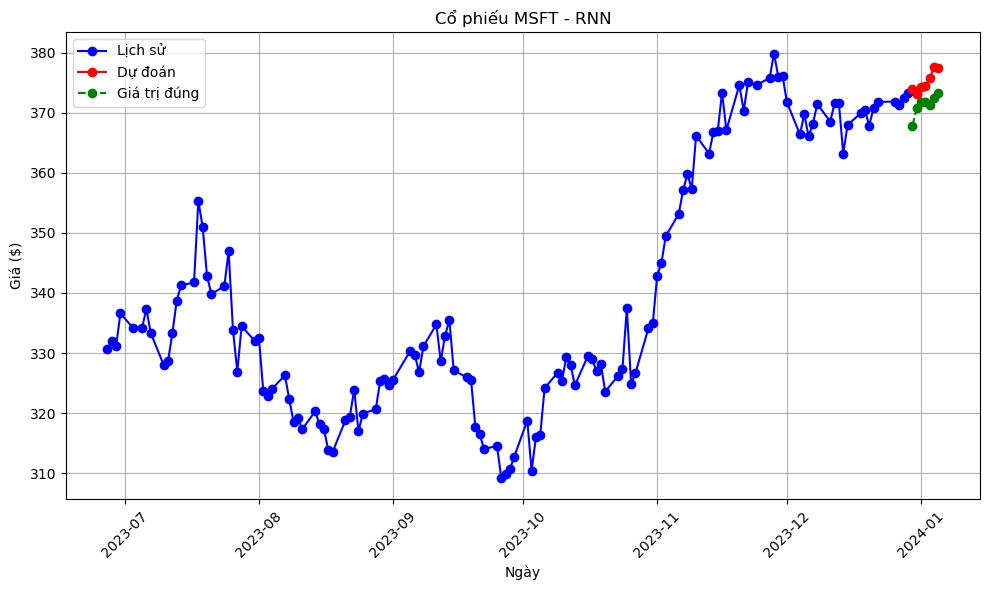

In [56]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Download MSFT data
msft = yf.download('MSFT', start='2023-01-01', end='2023-12-31')
data = msft[['Adj Close']].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Set lookback period
lookback = 100
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
    
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the model
model = Sequential([Input(shape=(lookback, 1)), SimpleRNN(50), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)

# Function to predict the next n days
def predict_next_days(model, last_sequence, n_days, scaler):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        current_sequence = current_sequence.reshape((1, lookback, 1))
        next_pred = model.predict(current_sequence, verbose=0)
        predictions.append(next_pred[0])
        
        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred
    
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)

# Prepare the last sequence for prediction
last_sequence = X[-1:]

# Predict the next 7 days
future_predictions = predict_next_days(model, last_sequence, 7, scaler)
future_dates = [msft.index[-1] + timedelta(days=i+1) for i in range(7)]

# Collect actual prices for comparison (last 7 days in the test set)
actual_prices_future = data[-7:] if len(data) >= 7 else np.array([]).reshape(-1, 1)

# Print predictions and actual values
print("Date\t\tPredicted Price\tActual Price")
for date, pred_price, actual_price in zip(future_dates, future_predictions, actual_prices_future):
    print(f"{date.strftime('%Y-%m-%d')}\t${pred_price[0]:.2f}\t\t${actual_price[0]:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))[-len(msft.index[train_size:]):]
plt.plot(msft.index[train_size:], actual_prices, color='blue', label='Lịch sử', marker='o', zorder=3)
plt.plot(future_dates, future_predictions, color='red', label='Dự đoán', marker='o', linestyle='-', zorder=5)
if actual_prices_future.size > 0:
    plt.plot(future_dates, actual_prices_future, color='green', label='Giá trị đúng', marker='o', linestyle='--', zorder=4)
plt.title('Cổ phiếu MSFT - RNN')
plt.xlabel('Ngày')
plt.ylabel('Giá ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_874/392044731.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred


Date		Predicted Price	Actual Price
2024-12-14	$441.83		$451.59
2024-12-15	$438.59		$454.46
2024-12-16	$440.95		$437.39
2024-12-17	$438.67		$437.03


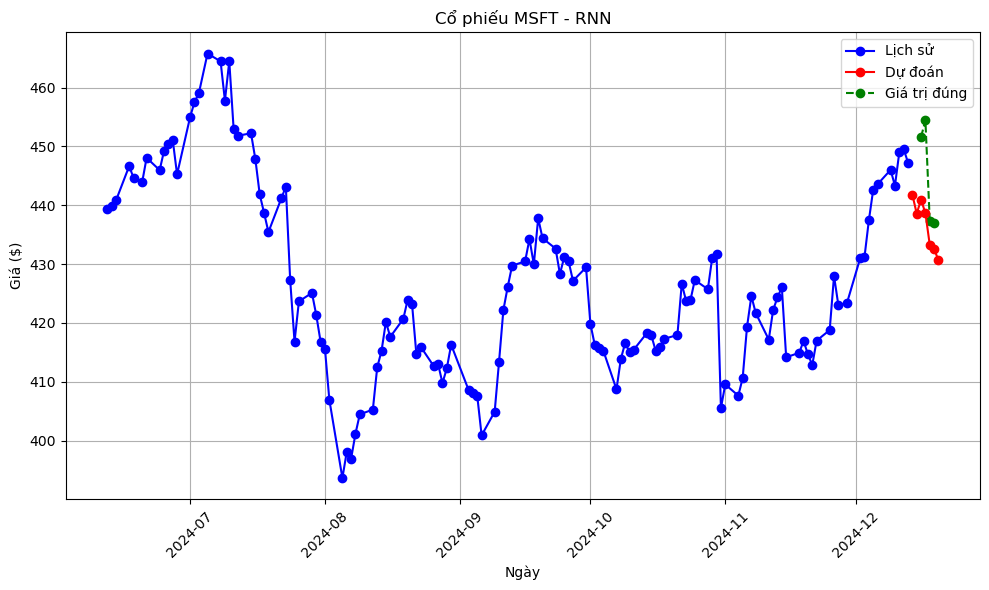

In [64]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Download MSFT data
end_date = datetime(2024, 12, 20)
data_end_date = datetime(2024, 12, 13)
msft = yf.download('MSFT', start='2024-01-01', end=end_date.strftime('%Y-%m-%d'))
if msft.empty:
    print("No data found for the specified date range.")
else:
    # Filter data for training (up to 13/12/2024)
    training_data = msft[msft.index <= data_end_date]
    data = training_data[['Adj Close']].values

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Set lookback period
    lookback = 100
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the model
    model = Sequential([Input(shape=(lookback, 1)), SimpleRNN(50), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)

    # Function to predict the next n days
    def predict_next_days(model, last_sequence, n_days, scaler):
        predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_days):
            current_sequence = current_sequence.reshape((1, lookback, 1))
            next_pred = model.predict(current_sequence, verbose=0)
            predictions.append(next_pred[0])

            # Update sequence
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[0, -1, 0] = next_pred

        predictions = np.array(predictions).reshape(-1, 1)
        return scaler.inverse_transform(predictions)

    # Prepare the last sequence for prediction
    last_sequence = scaled_data[-lookback:]
    last_sequence = last_sequence.reshape((1, lookback, 1))

    # Predict the next 7 days (13/12/2024 to 20/12/2024)
    future_predictions = predict_next_days(model, last_sequence, 7, scaler)
    future_dates = [data_end_date + timedelta(days=i+1) for i in range(7)]

    # Collect actual prices for the target dates
    actual_prices_future = msft[(msft.index > data_end_date) & (msft.index <= end_date)][['Adj Close']].values
    actual_dates = msft[(msft.index > data_end_date) & (msft.index <= end_date)].index

    # Print predictions and actual values
    print("Date\t\tPredicted Price\tActual Price")
    for date, pred_price, actual_price in zip(future_dates, future_predictions, actual_prices_future):
        print(f"{date.strftime('%Y-%m-%d')}\t${pred_price[0]:.2f}\t\t${actual_price[0]:.2f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))[-len(training_data.index[train_size:]):]
    plt.plot(training_data.index[train_size:], actual_prices, color='blue', label='Lịch sử', marker='o', zorder=3)
    plt.plot(future_dates, future_predictions, color='red', label='Dự đoán', marker='o', linestyle='-', zorder=5)
    if len(actual_dates) > 0:
        plt.plot(actual_dates, actual_prices_future, color='green', label='Giá trị đúng', marker='o', linestyle='--', zorder=4)
    plt.title('Cổ phiếu MSFT - RNN')
    plt.xlabel('Ngày')
    plt.ylabel('Giá ($)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_874/3820992195.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred
/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_874/3820992195.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred
/var/folders/0w/n8j1dj1s13d5mf73xzjt1f980000gn/T/ipykernel_874/3820992195.py:70: DeprecationWarning: Conver

MSFT - Bảng giá dự đoán:
      Date  MSFT_Predicted Price
2023-12-30            370.681213
2023-12-31            371.196747
2024-01-01            371.789398
2024-01-02            370.350555
2024-01-03            370.734955
2024-01-04            370.780792
2024-01-05            370.593170

--------------------------------------------------

AMD - Bảng giá dự đoán:
      Date  AMD_Predicted Price
2023-12-30           142.067032
2023-12-31           140.050873
2024-01-01           137.694382
2024-01-02           135.779755
2024-01-03           133.502472
2024-01-04           131.848419
2024-01-05           128.640442

--------------------------------------------------

JPM - Bảng giá dự đoán:
      Date  JPM_Predicted Price
2023-12-30           166.369522
2023-12-31           166.428238
2024-01-01           166.224869
2024-01-02           166.376175
2024-01-03           166.250717
2024-01-04           166.375183
2024-01-05           166.417023


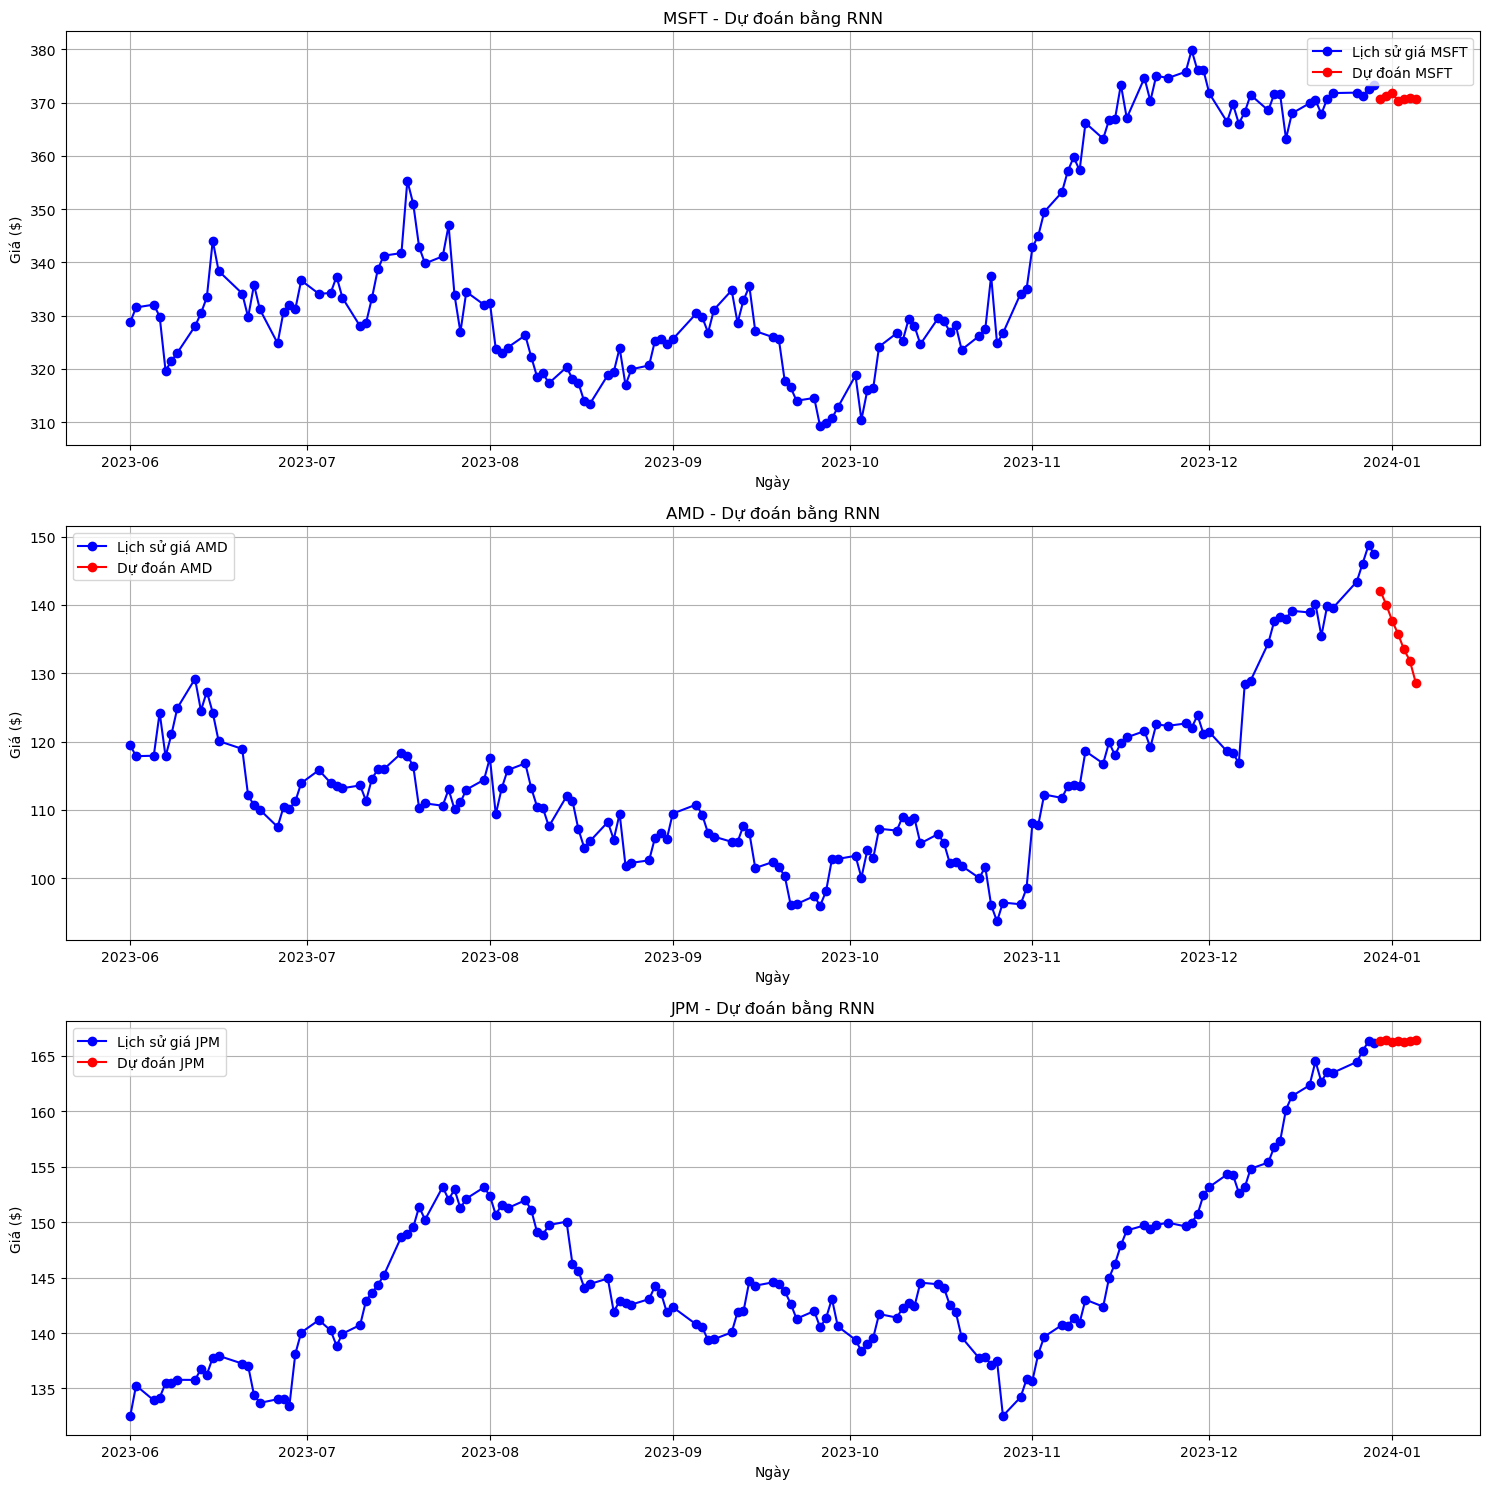

In [111]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
msft = yf.download('MSFT', start='2023-06-01', end='2023-12-31')
amd = yf.download('AMD', start='2023-06-01', end='2023-12-31')
jpm = yf.download('JPM', start='2023-06-01', end='2023-12-31')

def prepare_data(data, lookback=100):
    prices = data[['Adj Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices)
    
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler
    
lookback = 100
X_msft, y_msft, scaler_msft = prepare_data(msft, lookback)
X_amd, y_amd, scaler_amd = prepare_data(amd, lookback)
X_jpm, y_jpm, scaler_jpm = prepare_data(jpm, lookback)

train_size_msft = int(len(X_msft) * 0.8)
train_size_amd = int(len(X_amd) * 0.8)
train_size_jpm = int(len(X_jpm) * 0.8)

X_train_msft, X_test_msft = X_msft[:train_size_msft], X_msft[train_size_msft:]
y_train_msft, y_test_msft = y_msft[:train_size_msft], y_msft[train_size_msft:]

X_train_amd, X_test_amd = X_amd[:train_size_amd], X_amd[train_size_amd:]
y_train_amd, y_test_amd = y_amd[:train_size_amd], y_amd[train_size_amd:]

X_train_jpm, X_test_jpm = X_jpm[:train_size_jpm], X_jpm[train_size_jpm:]
y_train_jpm, y_test_jpm = y_jpm[:train_size_jpm], y_jpm[train_size_jpm:]

def build_model():
    model = Sequential([Input(shape=(lookback, 1)), SimpleRNN(50), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    return model

model_msft = build_model()
model_amd = build_model()
model_jpm = build_model()
model_msft.fit(X_train_msft, y_train_msft, epochs=20, batch_size=1, verbose=0)
model_amd.fit(X_train_amd, y_train_amd, epochs=20, batch_size=1, verbose=0)
model_jpm.fit(X_train_jpm, y_train_jpm, epochs=20, batch_size=1, verbose=0)

def predict_next_days(model, last_sequence, n_days, scaler):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        current_sequence = current_sequence.reshape((1, lookback, 1))
        next_pred = model.predict(current_sequence, verbose=0)
        predictions.append(next_pred[0])
        
        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred
    
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)
    
last_sequence_msft = X_msft[-1:]
last_sequence_amd = X_amd[-1:]
last_sequence_jpm = X_jpm[-1:]

# Predict the next 7 days
future_predictions_msft = predict_next_days(model_msft, last_sequence_msft, 7, scaler_msft)
future_predictions_amd = predict_next_days(model_amd, last_sequence_amd, 7, scaler_amd)
future_predictions_jpm = predict_next_days(model_jpm, last_sequence_jpm, 7, scaler_jpm)
future_dates = [msft.index[-1] + timedelta(days=i+1) for i in range(7)]

data_dict = {
    'Date': future_dates,
    'MSFT_Predicted Price': future_predictions_msft.flatten(),
    'AMD_Predicted Price': future_predictions_amd.flatten(),
    'JPM_Predicted Price': future_predictions_jpm.flatten(),}

print("MSFT - Bảng giá dự đoán:")
msft_results = pd.DataFrame(data_dict)[['Date', 'MSFT_Predicted Price']]
print(msft_results.to_string(index=False))
print("\n" + "-"*50 + "\n")

print("AMD - Bảng giá dự đoán:")
amd_results = pd.DataFrame(data_dict)[['Date', 'AMD_Predicted Price']]
print(amd_results.to_string(index=False))
print("\n" + "-"*50 + "\n")

print("JPM - Bảng giá dự đoán:")
jpm_results = pd.DataFrame(data_dict)[['Date', 'JPM_Predicted Price']]
print(jpm_results.to_string(index=False))

plt.figure(figsize=(15, 15))
# MSFT plot
plt.subplot(3, 1, 1)
plt.plot(msft.index[-180:], msft['Adj Close'][-180:], color='blue', label='Lịch sử giá MSFT', marker='o')
plt.plot(future_dates, future_predictions_msft, color='red', label='Dự đoán MSFT', marker='o')
plt.title('MSFT - Dự đoán bằng RNN')
plt.xlabel('Ngày')
plt.ylabel('Giá ($)')
plt.legend()
plt.grid(True)
# AMD plot
plt.subplot(3, 1, 2)
plt.plot(amd.index[-180:], amd['Adj Close'][-180:], color='blue', label='Lịch sử giá AMD', marker='o')
plt.plot(future_dates, future_predictions_amd, color='red', label='Dự đoán AMD', marker='o')
plt.title('AMD - Dự đoán bằng RNN')
plt.xlabel('Ngày')
plt.ylabel('Giá ($)')
plt.legend()
plt.grid(True)
# JPM plot
plt.subplot(3, 1, 3)
plt.plot(jpm.index[-180:], jpm['Adj Close'][-180:], color='blue', label='Lịch sử giá JPM', marker='o')
plt.plot(future_dates, future_predictions_jpm, color='red', label='Dự đoán JPM', marker='o')
plt.title('JPM - Dự đoán bằng RNN')
plt.xlabel('Ngày')
plt.ylabel('Giá ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2725  
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1116 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412 
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

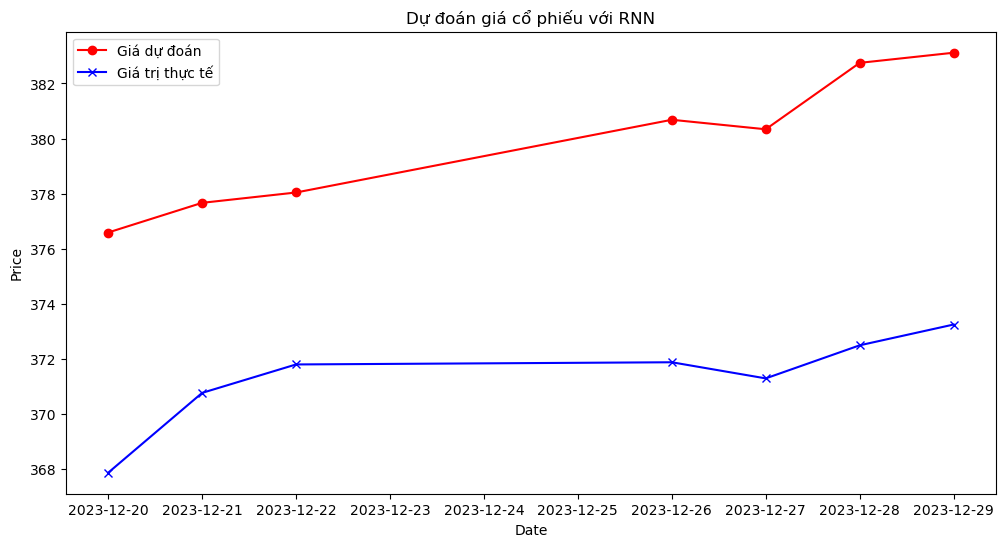

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Load dữ liệu (dữ liệu giá đóng cửa đã sẵn có)
data = msft['Adj Close'].values.reshape(-1, 1)  # Ví dụ với cổ phiếu MSFT
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Chuẩn bị dữ liệu cho RNN
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)

# Reshape dữ liệu
X = X.reshape(X.shape[0], X.shape[1], 1)

# Chia tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(50, activation='tanh', input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

# Dự đoán giá trị 7 ngày tiếp theo
last_60_days = data_scaled[-time_step:]
future_predictions = []
for _ in range(7):
    prediction = model.predict(last_60_days.reshape(1, time_step, 1), verbose=0)
    future_predictions.append(prediction[0, 0])
    last_60_days = np.vstack([last_60_days[1:], prediction])  # Thêm dự đoán vào chuỗi

# Chuyển đổi giá trị dự đoán về phạm vi thực tế
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# So sánh với giá trị thực tế nếu có
future_dates = msft.index[-7:]  # Lấy các ngày cuối cùng
actual_prices = data[-7:]  # Giá trị thực tế nếu có

# In ra giá trị dự đoán và thực tế
print("Date\t\tPredicted Price\tActual Price")
for i in range(7):
    print(f"{future_dates[i].date()}\t${future_predictions_actual[i, 0]:.2f}\t\t${actual_prices[i, 0] if i < len(actual_prices) else 'N/A'}")

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_actual, color='red', label='Giá dự đoán', marker='o')
if len(actual_prices) == len(future_dates):
    plt.plot(future_dates, actual_prices, color='blue', label='Giá trị thực tế', marker='x')
plt.title('Dự đoán giá cổ phiếu với RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0318
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6804e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.1733e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.8676e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.4837e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8101e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4329e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.2620e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9532e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train RMSE: 8.202494495449802
Test RMSE: 12.376729516303621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

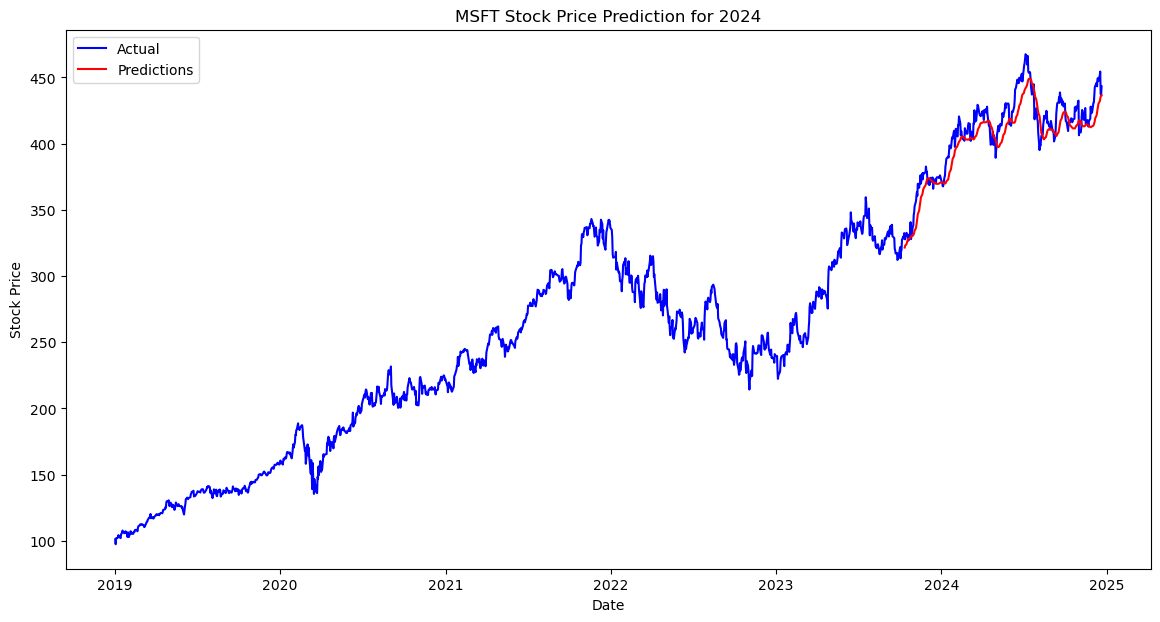

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tải dữ liệu cổ phiếu từ Yahoo Finance
ticker = 'MSFT'  
end_date = '2024-12-31'
start_date = '2019-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

if data.empty:
    print(f"Không có dữ liệu cho mã cổ phiếu {ticker}. Hãy kiểm tra lại mã cổ phiếu.")
else:
    # Lấy cột 'Close' (giá đóng cửa)
    data = data['Close']

    # Tiền xử lý dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

    # Hàm tạo dữ liệu cho mô hình
    def create_dataset(dataset, time_step=60):
        X, y = [], []
        for i in range(len(dataset) - time_step):
            X.append(dataset[i:i + time_step, 0])
            y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(y)

    # Chia dữ liệu
    train_size = int(len(data_scaled) * 0.8)
    train_data = data_scaled[:train_size]
    test_data = data_scaled[train_size - 60:]  # Lấy thêm 60 mẫu để tạo dữ liệu test

    time_step = 60
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Dự đoán
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Đảo ngược chuẩn hóa
    train_pred = scaler.inverse_transform(train_pred)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_pred = scaler.inverse_transform(test_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))

    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')

    # Dự đoán giá cho cả năm 2024
    future_days = 365  # Số ngày trong năm 2024
    last_60_days = data_scaled[-60:]
    future_predictions = []

    for _ in range(future_days):
        pred_input = last_60_days.reshape(1, -1, 1)
        pred = model.predict(pred_input)
        future_predictions.append(pred[0, 0])
        last_60_days = np.append(last_60_days[1:], pred, axis=0)

    # Chuyển đổi dự đoán về giá thực tế
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]

    # Lọc dữ liệu thực tế của 2024
    data_2024 = data[data.index.year == 2024]

    # Hiển thị kết quả thực tế và dự đoán
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual', color='blue')
    plt.plot(data.index[-len(y_test_actual):], test_pred, label='Predictions', color='red')
    plt.title('MSFT Stock Price Prediction for 2024')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0321
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6186e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9852e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.9334e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.4272e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3043e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.8632e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4446e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.5500e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━

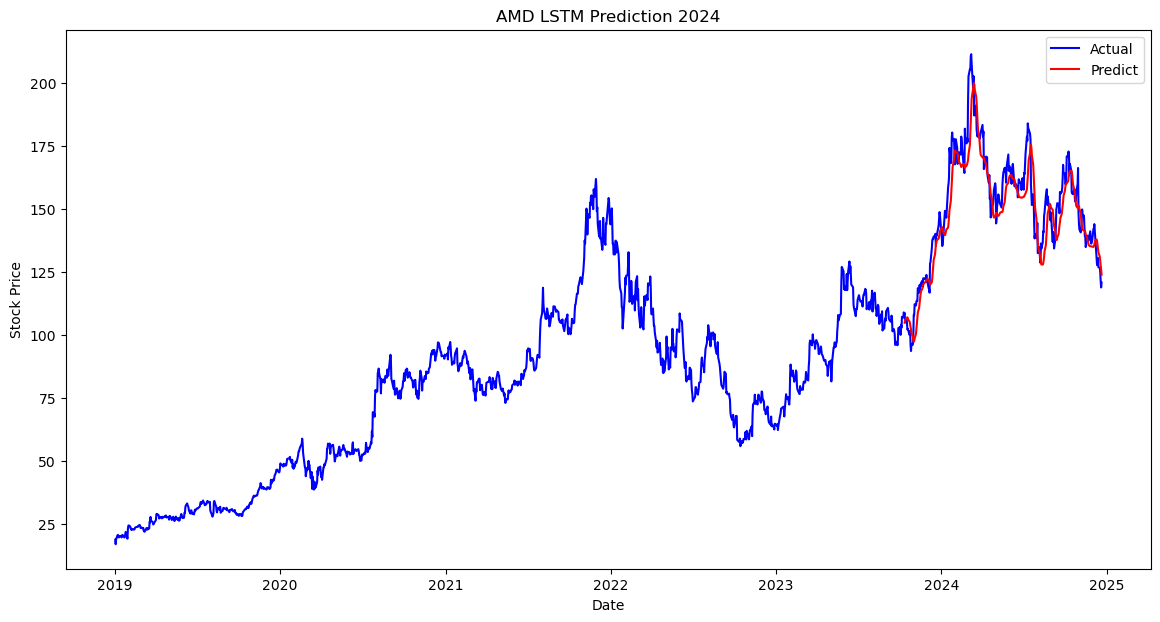

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
import yfinance as yf
data = yf.download('AMD', start='2019-01-01', end='2024-12-31')['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
train_size = int(len(data_scaled) * 0.8)
X_train, y_train = create_dataset(data_scaled[:train_size], time_step)
X_test, y_test = create_dataset(data_scaled[train_size - time_step:], time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 365
future_predictions = []
last_60_days = data_scaled[-time_step:]
for _ in range(future_days):
    pred = model.predict(last_60_days.reshape(1, -1, 1))[0, 0]
    future_predictions.append(pred)
    last_60_days = np.append(last_60_days[1:], pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]
comparison_df = pd.DataFrame({
    'Date': data.index[-len(test_pred):],
    'Actual': y_test_actual.flatten(),
    'Predicted': test_pred.flatten()})
print(comparison_df.head(10))
comparison_df.to_csv('AMD LSTM Predict.csv')

plt.figure(figsize=(14, 7))
plt.plot(data.index, data, label='Actual', color='blue')
plt.plot(data.index[-len(test_pred):], test_pred, label='Predict', color='red')
plt.title('AMD LSTM Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0777
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8042e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8618e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8669e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2177e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4896e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1528e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8444e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5501e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

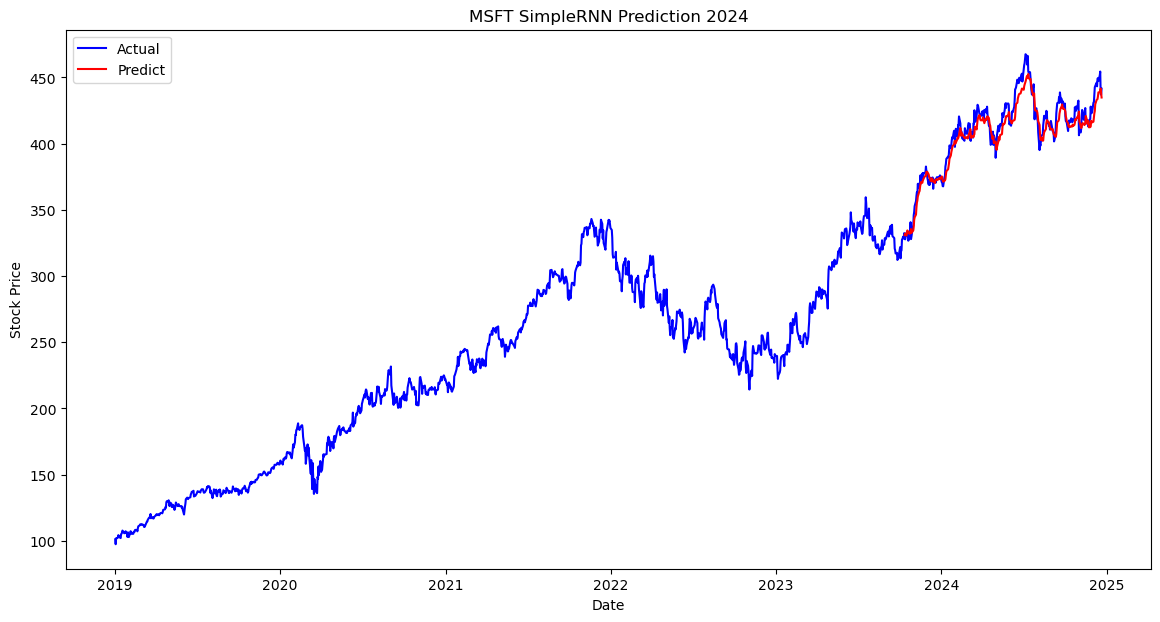

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd

data = yf.download('MSFT', start='2019-01-01', end='2024-12-31')['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
train_size = int(len(data_scaled) * 0.8)
X_train, y_train = create_dataset(data_scaled[:train_size], time_step)
X_test, y_test = create_dataset(data_scaled[train_size - time_step:], time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 365
future_predictions = []
last_60_days = data_scaled[-time_step:]
for _ in range(future_days):
    pred = model.predict(last_60_days.reshape(1, -1, 1))[0, 0]
    future_predictions.append(pred)
    last_60_days = np.append(last_60_days[1:], pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]
comparison_df = pd.DataFrame({
    'Date': data.index[-len(test_pred):],
    'Actual': y_test_actual.flatten(),
    'Predicted': test_pred.flatten()})
print(comparison_df.head(10))
comparison_df.to_csv('MSFT SimpleRNN Predict.csv')

plt.figure(figsize=(14, 7))
plt.plot(data.index, data, label='Actual', color='blue')
plt.plot(data.index[-len(test_pred):], test_pred, label='Predict', color='red')
plt.title('MSFT SimpleRNN Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        Date      Actual     Predict
0 2024-12-10  127.739998  131.140286
1 2024-12-11  130.149994  128.885423
2 2024-12-12  130.600006  132.090849
3 2024-12-13  126.910004  129.237636
4 2024-12-16  126.690002  126.273056
5 2024-12-17  125.019997  125.992695
6 2024-12-18  121.410004  124.474022
7 2024-12-19  118.879997  122.276710
8 2024-12-20  119.209999  120.313937


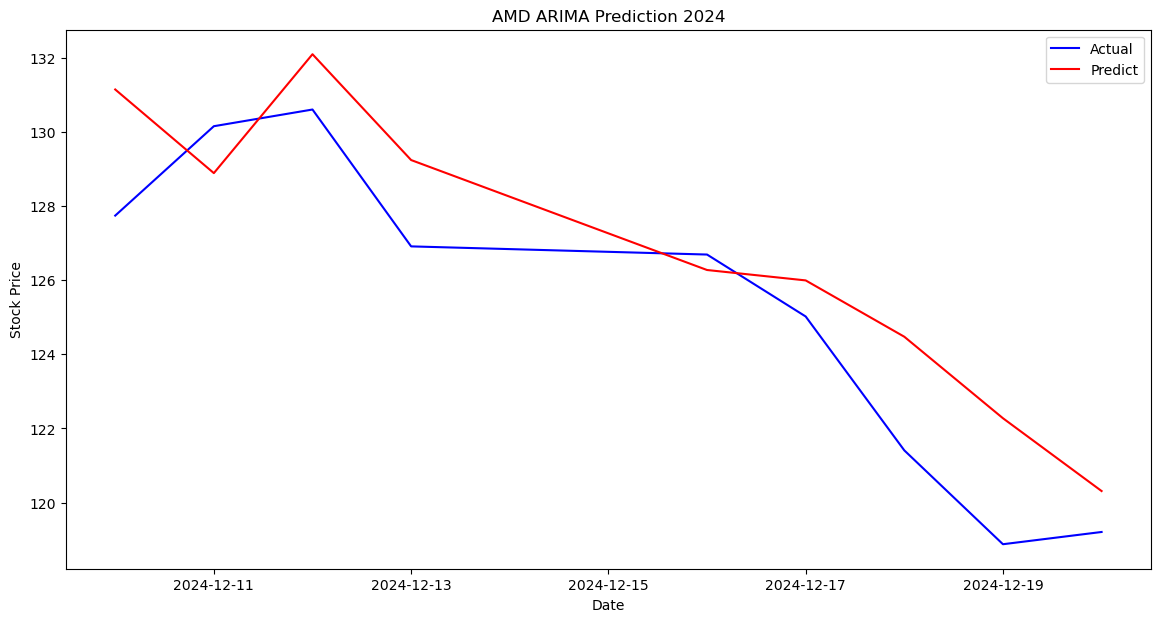

MAE: 1.937516549592137
MSE: 4.896235055062649
RMSE: 2.2127437843235827
R²: 0.7165679951405626
MAPE: 1.558140743277945%
Adjusted R²: 0.6760777087320715


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import timedelta, datetime

# Load data
stock_symbol = 'AMD'
data = yf.download(stock_symbol, start='2024-10-20', end='2024-12-20')['Close']
data_forecast = yf.download(stock_symbol, start='2024-12-10', end=datetime.now().strftime('%Y-%m-%d'))['Close']
data_combined = pd.concat([data, data_forecast])

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_combined.values.reshape(-1, 1))
data_train = data_scaled[:len(data)]
data_test = data_scaled[len(data):]

# Fit ARIMA model
order = (30, 2, 10)
model = ARIMA(data_train, order=order)
model_fit = model.fit()

# Forecast
future_steps = len(data_test)
forecast_scaled = model_fit.forecast(steps=future_steps)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

# Inverse transform for actual values
data_test_actual = scaler.inverse_transform(data_test.reshape(-1, 1))

# Save comparison dataframe
comparison_df = pd.DataFrame({
    'Date': data_forecast.index,
    'Actual': data_test_actual.flatten(),
    'Predict': forecast.flatten()})
print(comparison_df.head(10))
comparison_df.to_csv('AMD.csv', index=False)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(data_forecast.index, data_test_actual, label='Actual', color='blue')
plt.plot(data_forecast.index, forecast, label='Predict', color='red')
plt.title('AMD ARIMA Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate metrics
mae = mean_absolute_error(data_test_actual, forecast)
print(f'MAE: {mae}')

mse = mean_squared_error(data_test_actual, forecast)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(data_test_actual, forecast)
print(f'R²: {r2}')

mape = np.mean(np.abs((data_test_actual - forecast) / data_test_actual)) * 100
print(f'MAPE: {mape}%')

n = len(data_test_actual)  # Number of data points
p = 1  # Number of independent variables
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R²: {adjusted_r2}')

In [97]:
from pmdarima import auto_arima
import yfinance as yf
from datetime import timedelta

stock_symbol = 'AMD'
data = yf.download(stock_symbol, start='2019-01-01', end='2024-12-31')['Close']
model = auto_arima(data, seasonal=False, stepwise=True, trace=True)

print(model.summary())

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7763.027, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7760.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7761.578, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7761.560, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7759.453, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7763.508, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.866 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1505
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3878.727
Date:                Mon, 23 Dec 2024   AIC                           7759.453
Time:                        22:16:44   BIC                           7764.769
Sample:                             0   HQIC                          7761.433
          

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0351
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3803e-04
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2103e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2997e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0064e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7583e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7793e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0576e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7907e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

[*********************100%***********************]  1 of 1 completed


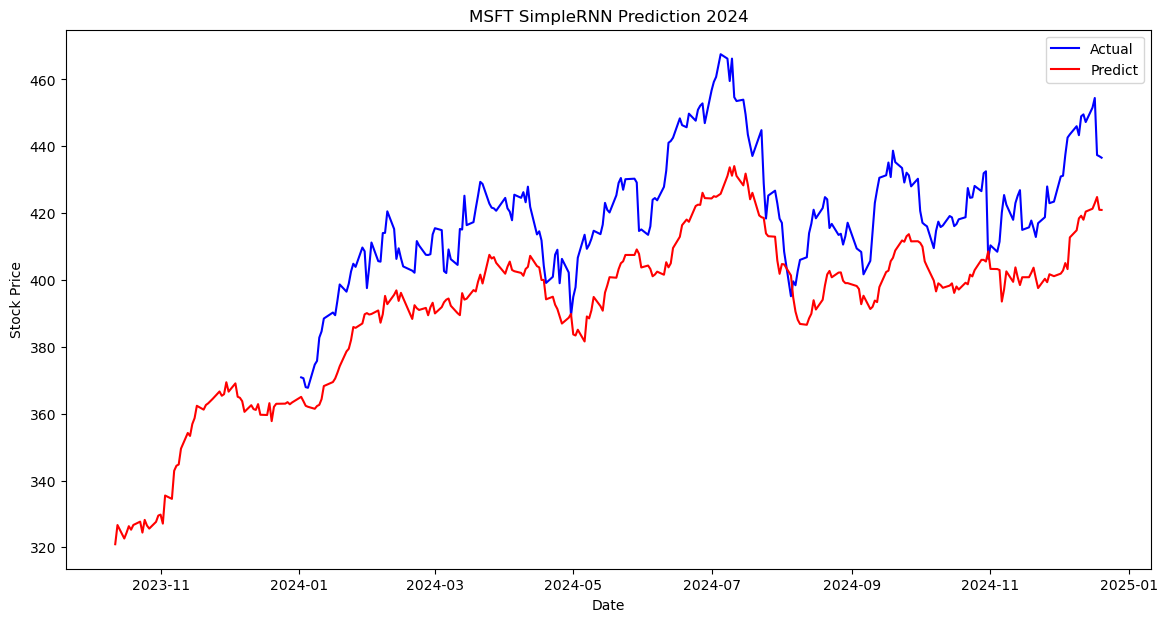

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
data = yf.download('MSFT', start='2019-01-01', end='2024-12-31')['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
train_size = int(len(data_scaled) * 0.8)
X_train, y_train = create_dataset(data_scaled[:train_size], time_step)
X_test, y_test = create_dataset(data_scaled[train_size - time_step:], time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 365
future_predictions = []
last_60_days = data_scaled[-time_step:]
for _ in range(future_days):
    pred = model.predict(last_60_days.reshape(1, -1, 1))[0, 0]
    future_predictions.append(pred)
    last_60_days = np.append(last_60_days[1:], pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]
comparison_df = pd.DataFrame({
    'Date': data.index[-len(test_pred):],
    'Actual': y_test_actual.flatten(),
    'Predicted': test_pred.flatten()})
print(comparison_df.head(10))
comparison_df.to_csv('MSFT.csv')
data1= yf.download('MSFT', start='2024-01-01', end='2024-12-31')['Close']
plt.figure(figsize=(14, 7))
plt.plot(data1.index, data1, label='Actual', color='blue')
plt.plot(data.index[-len(test_pred):], test_pred, label='Predict', color='red')
plt.title('MSFT SimpleRNN Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.1201
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0061
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0026
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0012
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0011
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 9.4865e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 8.6376e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 8.1317e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 8.2368e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 7.9222e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed


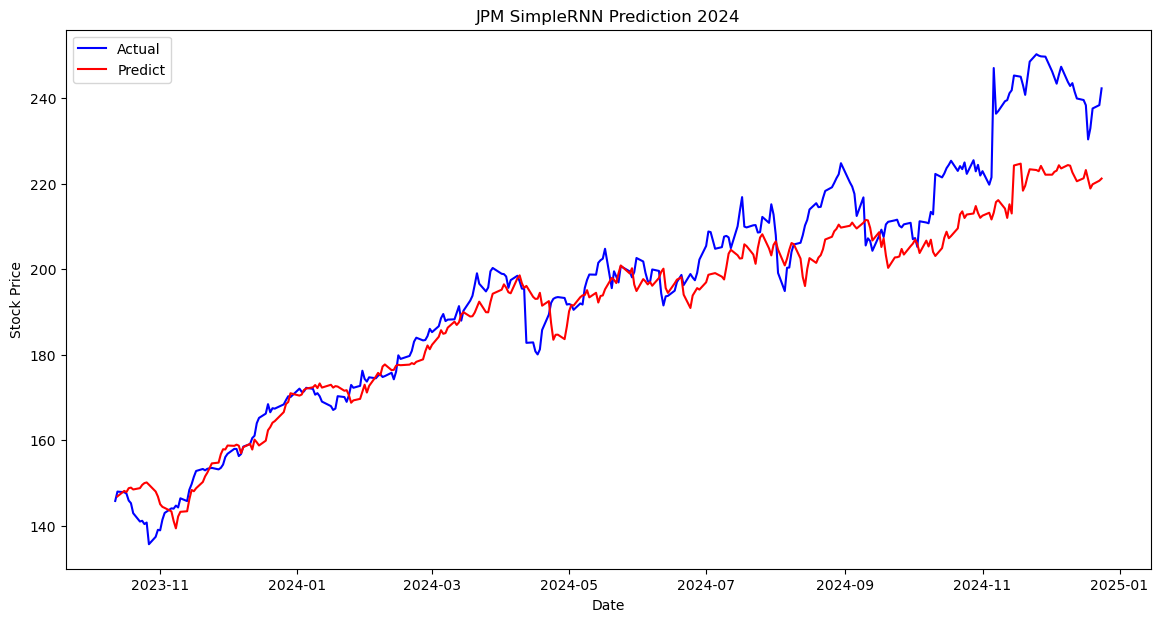

MAE: 6.968082049035079
MSE: 95.01233989432674
RMSE: 9.747427347476192
R²: 0.8771391629985064
MAPE: 3.326556098397191%
Adjusted R²: 0.8767296268751681


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
import pandas as pd
data = yf.download('JPM', start='2019-01-01', end='2024-12-31')['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=900):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 900
train_size = int(len(data_scaled) * 0.8)
X_train, y_train = create_dataset(data_scaled[:train_size], time_step)
X_test, y_test = create_dataset(data_scaled[train_size - time_step:], time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 365
future_predictions = []
last_900_days = data_scaled[-time_step:]
for _ in range(future_days):
    pred = model.predict(last_900_days.reshape(1, -1, 1))[0, 0]
    future_predictions.append(pred)
    last_900_days = np.append(last_900_days[1:], pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]
comparison_df = pd.DataFrame({
    'Date': data.index[-len(test_pred):],
    'Actual': y_test_actual.flatten(),
    'Predict': test_pred.flatten()})
print(comparison_df.head(10))
data1= yf.download('JPM', start='2023-10-12', end='2024-12-31')['Close']
plt.figure(figsize=(14, 7))
plt.plot(data1.index, data1, label='Actual', color='blue')
plt.plot(data.index[-len(test_pred):], test_pred, label='Predict', color='red')
plt.title('JPM SimpleRNN Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

mae = mean_absolute_error(y_test_actual, test_pred)
print(f'MAE: {mae}')

mse = mean_squared_error(y_test_actual, test_pred)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test_actual, test_pred)
print(f'R²: {r2}')

mape = np.mean(np.abs((y_test_actual - test_pred) / y_test_actual)) * 100
print(f'MAPE: {mape}%')

n = len(y_test_actual)  # Số lượng điểm dữ liệu
p = 1  # Số lượng biến độc lập
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R²: {adjusted_r2}')

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6746
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 0.5304
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 0.4126
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.3139
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2300
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1583
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0978
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0491
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0150
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 2.3765e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[*********************100%***********************]  1 of 1 completed

        Date      Actual     Predict
0 2023-10-13  327.730011  365.676727
1 2023-10-16  332.640015  366.072083
2 2023-10-17  332.059998  366.566559
3 2023-10-18  330.109985  367.119598
4 2023-10-19  331.320007  367.682007
5 2023-10-20  326.670013  368.250763
6 2023-10-23  329.320007  368.746216
7 2023-10-24  330.529999  369.198944
8 2023-10-25  340.670013  369.620270
9 2023-10-26  327.890015  370.148834


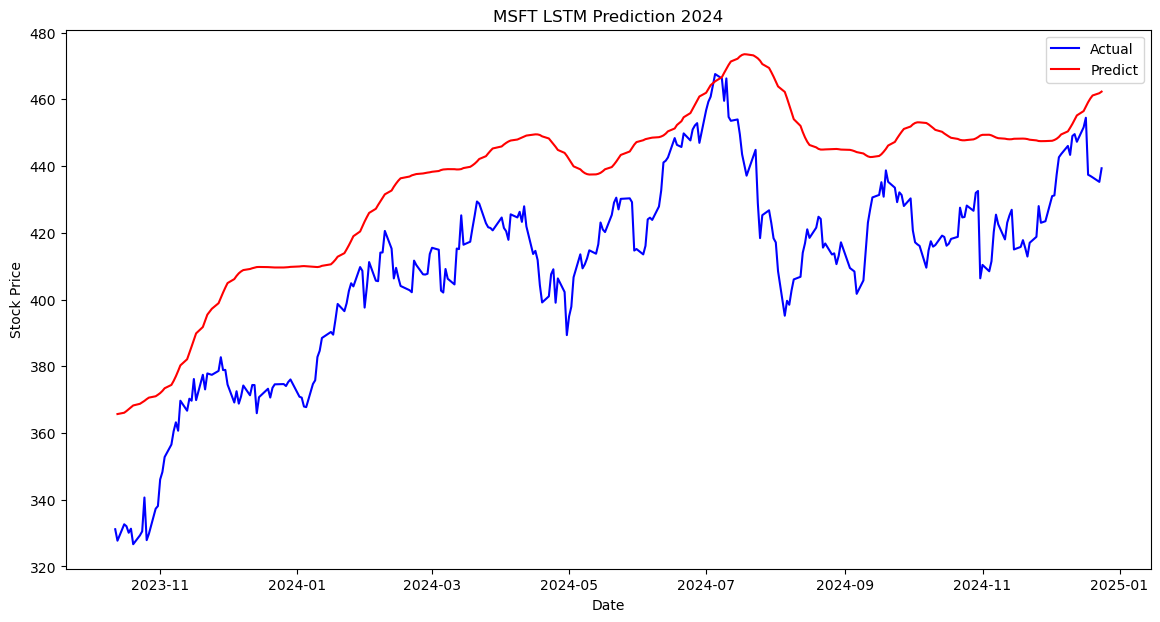

MAE: 26.081211014299207
MSE: 826.2470255698424
RMSE: 28.74451296456147
R²: 0.004871041882598792
MAPE: 6.500049553809328%
Adjusted R²: 0.0015539453555407645


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
import pandas as pd

data = yf.download('MSFT', start='2019-01-01', end='2024-12-31')['Close']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=1200):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 1200
train_size = int(len(data_scaled) * 0.8)
X_train, y_train = create_dataset(data_scaled[:train_size], time_step)
X_test, y_test = create_dataset(data_scaled[train_size - time_step:], time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 365
future_predictions = []
last_900_days = data_scaled[-time_step:]
for _ in range(future_days):
    pred = model.predict(last_900_days.reshape(1, -1, 1), verbose=0)[0, 0]
    future_predictions.append(pred)
    last_900_days = np.append(last_900_days[1:], pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(future_days)]
comparison_df = pd.DataFrame({
    'Date': data.index[-len(test_pred):],
    'Actual': y_test_actual.flatten(),
    'Predict': test_pred.flatten()})
print(comparison_df.head(10))
data1 = yf.download('MSFT', start='2023-10-12', end='2024-12-31')['Close']
plt.figure(figsize=(14, 7))
plt.plot(data1.index, data1, label='Actual', color='blue')
plt.plot(data.index[-len(test_pred):], test_pred, label='Predict', color='red')
plt.title('MSFT LSTM Prediction 2024')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

mae = mean_absolute_error(y_test_actual, test_pred)
print(f'MAE: {mae}')

mse = mean_squared_error(y_test_actual, test_pred)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test_actual, test_pred)
print(f'R²: {r2}')

mape = np.mean(np.abs((y_test_actual - test_pred) / y_test_actual)) * 100
print(f'MAPE: {mape}%')

n = len(y_test_actual)  # Số lượng điểm dữ liệu
p = 1  # Số lượng biến độc lập
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R²: {adjusted_r2}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


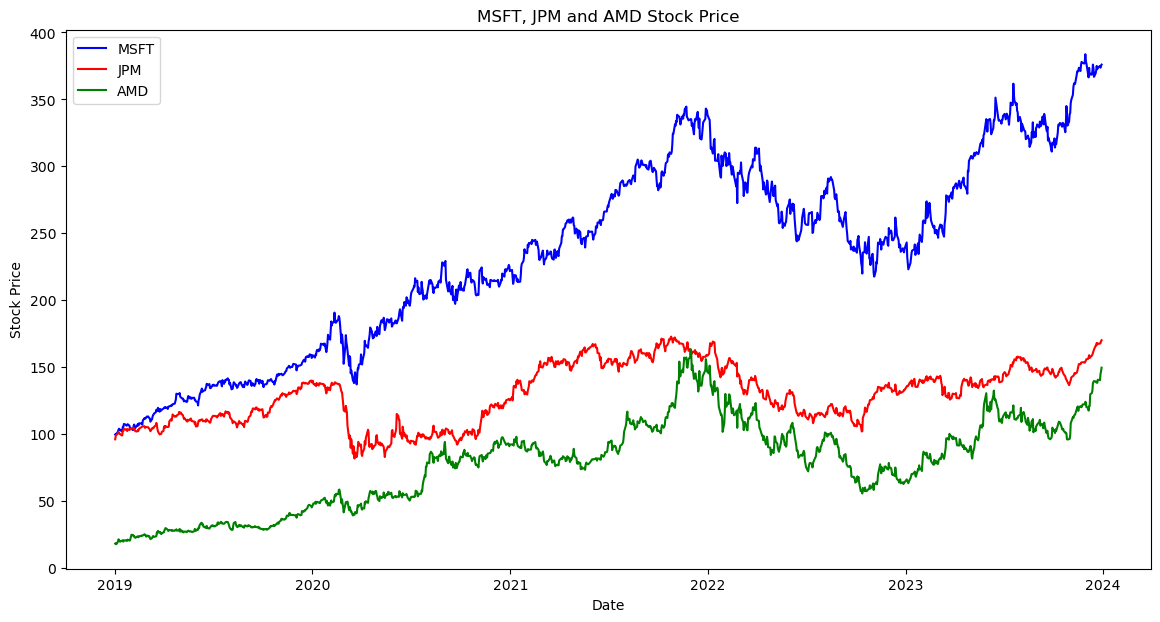

In [170]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 12, 31)

data1 = yf.download('MSFT', start=start_date, end=end_date)
data2 = yf.download('JPM', start=start_date, end=end_date)
data3 = yf.download('AMD', start=start_date, end=end_date)

plt.figure(figsize=(14, 7))
plt.title('MSFT, JPM and AMD Stock Price')
plt.plot(data1['Open'], label='MSFT', color='blue')
plt.plot(data2['Open'], label='JPM', color='red')
plt.plot(data3['Open'], label='AMD', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.show()